## CL-Gym Example: Stable A-GEM on Rotated MNIST

In this example, we use Averaged Gradient Episodic Memory (A-GEM) to train on Rotated MNIST benchmark. We use the stable version of [AGEM](https://arxiv.org/abs/1812.00420.pdf) using [Stable SGD](https://proceedings.neurips.cc/paper/2020/file/518a38cc9a0173d0b2dc088166981cf8-Paper.pdf) parameters.

## 1. Defining Parameters
First, we need to define our parameters/config for our experiment.
We define all our parameters inside a python dictionary. The parameters define different aspects of continual learning examples. For example:
-  How many tasks should we learn?
-  What our batch-size will be?
-  What Optimizer will we use?
-  Where should we store our outputs?

In [1]:
import torch
import numpy as np
import cl_gym as cl
# first let's create params/config for our experiment
noise = 0.05

def make_params() -> dict:
    import os
    from pathlib import Path
    import uuid

    params = {
            # benchmark
            'seed': 1,
            'num_tasks': 5,
            'epochs_per_task': 5,
            'per_task_memory_examples': 50,
            'batch_size_train': 64,
            'batch_size_memory': 200,
            'batch_size_validation': 256,

            # algorithm
            'optimizer': 'SGD',
            'learning_rate': 0.01,
            'momentum': 0.8,
            'learning_rate_decay': 1.0,
            'criterion': torch.nn.CrossEntropyLoss(),
            'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'), }

#     trial_id = str(uuid.uuid4())
    trial_id = f"seed={params['seed']}_epoch={params['epochs_per_task']}_{noise=}__"
    params['trial_id'] = trial_id
    params['output_dir'] = os.path.join("./outputs/{}".format(trial_id))
    print(f"output_dir={params['output_dir']}")
    Path(params['output_dir']).mkdir(parents=True, exist_ok=True)

    return params

## 2. Training our continual learning algorithm

Before seeing the code, let's explain the components one more time:
### 2.1 Benchmark
* We use the `RotatedMNIST` benchmark for this example. The benchmark includes gradual rotations of MNIST digits for each task. Something like this.
<div>
<img src="https://user-images.githubusercontent.com/8312051/122752221-845a0300-d245-11eb-8892-7c4119ffe1a5.png" width="300"/>
</div>

In CL-Gym we use RotatedMNIST as follows:
```python
benchmark = cl.benchmarks.RotatedMNIST(num_tasks=5)
```
---------

### 2.2 Backbone

* We use a MLP model with two hidden layers like this:
<div>
<img src="https://user-images.githubusercontent.com/8312051/122753641-67beca80-d247-11eb-87d3-dec5cc2e63d6.png" width="300"/>
</div>

To import our backbone, we use:
```python
backbone = cl.backbones.MLP2Layers(input_dim=784, hidden_dim_1=100, hidden_dim_2=100, output_dim=10)
```

You can also create your own PyTorch models. The backbone in CL-Gym is simply a lightweight wrapper around PyTorch's ``nn.Module``.

--------

### 2.3 Collecting metrics with Callbacks

The `MetricCollector` callback evaluates the model at the end of each epoch, logs the metrics, plots the accuraies to file, and stores the validation accuracies as numpy arrays to file (see outputs folder).
```python
metric_callback = cl.callbacks.MetricCollecto(num_tasks=5,
                                              eval_interval='epoch',
                                              epochs_per_task=1)
```

-------

### 2.4  Using off-the-shelf continual learning algorithms

CL-Gym includes several continual learning algorithms. Here we use A-GEM algorithm with better parameters than the original paper:

```python
cl.algorithms.AGEM(backbone, benchmark, params)
```

You can also use other algorithms. For example, for Experience Replay method, you can use:
```python
cl.algorithms.ERRingBuffer(backbone, benchmark, params)
```


-------

### 2.5 Gluing everything together with the Trainer

The `Trainer` will orchestrate the experiment by handling the non-research part of continual learning experiments.

```
trainer = cl.trainer.ContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])
```


The code below implements this note:

In [2]:
from datasets.FairMNIST import NoiseMNIST
from trainers.FairContinualTrainer import FairContinualTrainer

params = make_params()
benchmark = NoiseMNIST(num_tasks=params['num_tasks'], noise_size=noise,
# benchmark = cl.benchmarks.SplitMNIST(num_tasks=params['num_tasks'],
                                        per_task_memory_examples=params['per_task_memory_examples'])
# backbone: MLP with 2 hidden layers
backbone = cl.backbones.MLP2Layers(input_dim=784, hidden_dim_1=32, hidden_dim_2=32, output_dim=10)

output_dir=./outputs/seed=1_epoch=5_noise=0.05__


In [3]:
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset

"""
Need to modify self.memory_indices_train/test[task] depends on selection based on certain criteria
After every training task ends, load_memory_joint() is called
self: benchmark
Original selection code:
    def load_memory_joint(self,
                          task: int,
                          batch_size: int,
                          shuffle: Optional[bool] = True,
                          num_workers: Optional[int] = 0,
                          pin_memory: Optional[bool] = True) -> Tuple[DataLoader, DataLoader]:
        if task > self.num_tasks:
            raise ValueError(f"Asked to load memory of task={task} but the benchmark has {self.num_tasks} tasks")
        trains, tests = [], []
        for t in range(1, task + 1):
            train_indices = self.memory_indices_train[t]
            test_indices = self.memory_indices_test[t]
            train_dataset = Subset(self.trains[t], train_indices)
            test_dataset = Subset(self.tests[t], test_indices)
            trains.append(train_dataset)
            tests.append(test_dataset)
    
        trains, tests = ConcatDataset(trains), ConcatDataset(tests)
        train_loader = DataLoader(trains, batch_size, shuffle, num_workers=num_workers, pin_memory=pin_memory)
        test_loader = DataLoader(tests, batch_size, shuffle, num_workers=num_workers, pin_memory=pin_memory)
        print(f"{len(train_loader.dataset)=}")
        return train_loader, test_loader
"""


In [4]:
# Algorithm: A-GEM
# algorithm = cl.algorithms.AGEM(backbone, benchmark, params)
from algorithms.heuristic import Heuristic1

algorithm = Heuristic1(backbone, benchmark, params)
# algorithm = cl.algorithms.ERRingBuffer(backbone, benchmark, params)

# Callbacks
metric_manager_callback = cl.callbacks.MetricCollector(num_tasks=params['num_tasks'],
                                                        eval_interval='epoch',
                                                        epochs_per_task=params['epochs_per_task'])

# Make trainer
trainer = FairContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])

trainer.run()
print("final avg-acc", metric_manager_callback.meters['accuracy'].compute_final())
print("final avg-forget", metric_manager_callback.meters['forgetting'].compute_final())


---------------------------- Task 1 -----------------------
[1] Eval metrics for task 1 >> {'accuracy': 99.90543735224587, 'loss': 1.4620482119077698e-05}
[2] Eval metrics for task 1 >> {'accuracy': 99.90543735224587, 'loss': 2.6831826818204236e-05}
[3] Eval metrics for task 1 >> {'accuracy': 99.90543735224587, 'loss': 9.386498375353239e-06}
[4] Eval metrics for task 1 >> {'accuracy': 99.90543735224587, 'loss': 8.340675738006037e-06}
[5] Eval metrics for task 1 >> {'accuracy': 99.90543735224587, 'loss': 9.86764429029227e-06}
training_task_end
### modified_load_memory_joint called ###


NameError: name 'self' is not defined

In [5]:
0: 
[100] Eval metrics for task 1 >> {'accuracy': 62.174940898345156, 'loss': 0.0055100416460781235}
[100] Eval metrics for task 2 >> {'accuracy': 22.18413320274241, 'loss': 0.014497039016850665}
[100] Eval metrics for task 3 >> {'accuracy': 16.542155816435432, 'loss': 0.02120432299000222}
[100] Eval metrics for task 4 >> {'accuracy': 32.32628398791541, 'loss': 0.01416884592292532}
[100] Eval metrics for task 5 >> {'accuracy': 99.44528492183561, 'loss': 5.864381270724538e-05}
final avg-acc 46.53455976545481
final avg-forget 66.42999716205054



0.2: final avg-acc 76.14613653468083
[25] Eval metrics for task 1 >> {'accuracy': 85.34278959810875, 'loss': 0.003105571563080411}
[25] Eval metrics for task 2 >> {'accuracy': 57.14985308521058, 'loss': 0.011534252199440114}
[25] Eval metrics for task 3 >> {'accuracy': 59.338313767342584, 'loss': 0.00836346536206843}
[25] Eval metrics for task 4 >> {'accuracy': 80.61430010070494, 'loss': 0.0030969298498147923}
[25] Eval metrics for task 5 >> {'accuracy': 98.28542612203732, 'loss': 0.00018785794726298183}


0.5: final avg-acc 75.44106967096454
[25] Eval metrics for task 1 >> {'accuracy': 86.80851063829788, 'loss': 0.002922968097894186}
[25] Eval metrics for task 2 >> {'accuracy': 55.72967678746327, 'loss': 0.01418125139044034}
[25] Eval metrics for task 3 >> {'accuracy': 58.53788687299893, 'loss': 0.010533042753009939}
[25] Eval metrics for task 4 >> {'accuracy': 78.54984894259819, 'loss': 0.0037077458243355652}
[25] Eval metrics for task 5 >> {'accuracy': 97.57942511346445, 'loss': 0.00022127172912964603}


1.0: final avg-acc 76.64854615056723
[25] Eval metrics for task 1 >> {'accuracy': 84.86997635933807, 'loss': 0.0036403921479029014}
[25] Eval metrics for task 2 >> {'accuracy': 60.72477962781587, 'loss': 0.012811364319602376}
[25] Eval metrics for task 3 >> {'accuracy': 58.69797225186766, 'loss': 0.011527608781893963}
[25] Eval metrics for task 4 >> {'accuracy': 80.71500503524673, 'loss': 0.0035492324637022145}
[25] Eval metrics for task 5 >> {'accuracy': 98.23499747856782, 'loss': 0.00019328417355101696}


SyntaxError: invalid syntax (3563006957.py, line 1)

In [ ]:
0 --> 72


0.00 --> 59
0.02 --> 57
0.05 --> 54
0.10 --> 55
0.15 --> 43
0.20 --> 40


In [ ]:
final avg-acc 37.00841712522718
final avg-forget 66.60915398117396


In [ ]:
import matplotlib.pyplot as plt
import torchvision
import copy
import numpy as np
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.1307, 0.3081),
])

sensitive_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation([90, 90]),
    torchvision.transforms.RandomErasing(p = 1, scale=(0.02, 0.2)),
])

from datasets.FairMNIST import FairMNIST
dir = "/home/jaeyoung/anaconda3/envs/cl-gym/lib/python3.8/site-packages/cl_gym/data"
train = FairMNIST(dir, train=True, download=True, transform=transforms)


In [ ]:
train_len = len(train)
train_sensitive_idx = np.sort(np.random.choice(train_len, train_len//2, replace=False))
print(train_sensitive_idx)
sensitive = np.zeros(train_len)
sensitive[train_sensitive_idx] = np.ones_like(train_sensitive_idx)
print(sensitive)

[    1     2     4 ... 59996 59998 59999]
[0. 1. 1. ... 0. 1. 1.]


In [ ]:
def bool2idx(arr):
    idx = list()
    for i, e in enumerate(arr):
        if e == 1:
            idx.append(i)
    return np.array(idx)
train.data[bool2idx(sensitive)].shape

torch.Size([30000, 28, 28])

In [ ]:
import matplotlib.pyplot as plt
import torchvision
import copy

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.1307, 0.3081),
])

sensitive_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation([90, 90]),
    torchvision.transforms.RandomErasing(p = 1, scale=(0.02, 0.1)),
])


In [ ]:
from cl_gym.benchmarks.utils import DEFAULT_DATASET_DIR
from cl_gym.benchmarks.transforms import get_default_mnist_transform
mnist_train = torchvision.datasets.MNIST(DEFAULT_DATASET_DIR, train=True, download=True, transform=transforms)
original = copy.deepcopy(mnist_train.data)

In [ ]:
import numpy as np
a = np.sort(np.random.choice(len(mnist_train), len(mnist_train)//2, replace=False))
a

array([    0,     1,     4, ..., 59996, 59998, 59999])

Text(0.5, 1.0, 'transform')

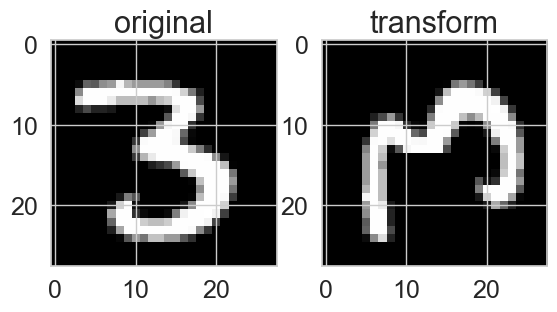

In [ ]:
from torchvision.transforms.functional import to_pil_image
from matplotlib import pyplot as plt


idx = 12

img = original[idx]
trans = sensitive_transform(mnist_train.data)[idx]

plt.figure()
plt.subplot(1,2,1)
plt.imshow(to_pil_image(img), cmap='gray')
plt.title('original')
plt.subplot(1,2,2)
plt.imshow(to_pil_image(trans), cmap='gray')
plt.title('transform')


In [ ]:
def tranform_on_idx(data, idx, transform):
    # if len(data) != len(idx):
    #     raise ValueError(f"size of data({len(data)}) and index({len(idx)}) is different")
    transformed = transform(data[idx])
    data[idx] = transformed
    return data

In [ ]:
data = tranform_on_idx(mnist_train.data, a, sensitive_transform)

Text(0.5, 1.0, 'transform')

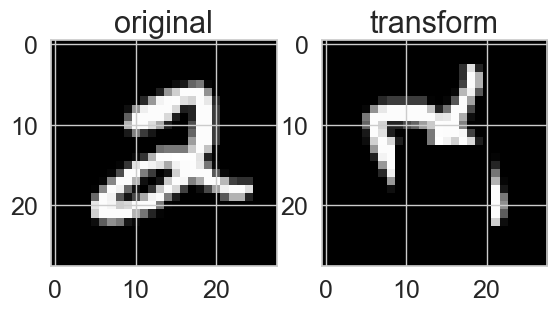

In [ ]:
from torchvision.transforms.functional import to_pil_image
from matplotlib import pyplot as plt


idx = 5
img = original[idx]
trans = data[idx]

plt.figure()
plt.subplot(1,2,1)
plt.imshow(to_pil_image(img), cmap='gray')
plt.title('original')
plt.subplot(1,2,2)
plt.imshow(to_pil_image(trans), cmap='gray')
plt.title('transform')
